<h1 id="tocheading">Fraud Detection with XGBoost and Machine Learning in DSX Local</h1>
<div id="toc"></div>


In [288]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [289]:
#run the line above to generate Table of Contents if it's not there

## Imports

In [285]:
import xgboost
print(xgboost.__version__)
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn_pandas import DataFrameMapper
import brunel

import matplotlib.pyplot as plt
%matplotlib inline

0.7.post3


## Load Data

In [8]:
import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/History_Transactions_v4.csv')
# only keep variables we will use later
df_data_1 = df_data_1[['Dollar_Amount', 
                       'Transaction_Type',
                       'Store_Type', 
                       'Cardholder_Region', 
                       'Country',
                       'Fraudulent',
                       'Last3hourTransactions',
                       'Hours_Since_Last_Transaction'
                      ]]
df_data_1.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Fraudulent,Last3hourTransactions,Hours_Since_Last_Transaction
0,188.56,swiped,ATM Withdrawal,E,USA,F,4,21
1,160.54,keyed,Grocery,NE,Australia,F,3,21
2,153.24,swiped,Retail - Pharmacy,SW,European Union,T,2,21
3,148.66,keyed,Communications - telephone and wireless,NW,USA,F,1,35
4,174.03,keyed,Spa/Beauty,SW,Asia,F,1,25


## Exploratory Data Analysis

In [21]:
# check missing
df_data_1.apply(lambda x: sum(x.isnull()))

Dollar_Amount                   0
Transaction_Type                0
Store_Type                      0
Cardholder_Region               0
Country                         0
Fraudulent                      0
Last3hourTransactions           0
Hours_Since_Last_Transaction    0
dtype: int64

In [25]:
# Look at categorical variables
var = ['Fraudulent', 'Transaction_Type', 'Store_Type', 'Cardholder_Region', 'Country']
for v in var:
    print("****************************************")
    print('\nFrequency count for variable %s'%v)
    print(df_data_1[v].value_counts())

****************************************

Frequency count for variable Fraudulent
F    52132
T     2903
Name: Fraudulent, dtype: int64
****************************************

Frequency count for variable Transaction_Type
swiped    27623
keyed     27412
Name: Transaction_Type, dtype: int64
****************************************

Frequency count for variable Store_Type
Restaurant                                 4470
Professional Services                      3443
Grocery                                    3403
Gas                                        3261
Other                                      3226
Hotel                                      3206
Retail - Apparel                           2276
ATM Withdrawal                             2240
Retail - Furniture                         2232
Entertainment and Arts                     2207
Retail - Home Improvement                  2194
Retail - Drug Store                        2193
Communications - telephone and wireless    2191
Me

## Split into Training and Test

In [9]:
y = df_data_1['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X = df_data_1.drop(['Fraudulent'], axis=1)

from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)

print("Number of training records: " + str(len(X_train)))
print("Number of testing records : " + str(len(X_test)))

Number of training records: 44028
Number of testing records : 11007


/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Handle Imbalance using SMOTE(only on Training set)

In [12]:
!pip install imblearn

    100% |████████████████████████████████| 153kB 995kB/s eta 0:00:01


In [13]:
# restart kernel if see error
from imblearn.over_sampling import SMOTE

In [14]:
X_train_dummy = pd.get_dummies(X_train)
sm = SMOTE(random_state=2662761, ratio = 'auto', k_neighbors = 5)
X_train_res, y_train_res = sm.fit_sample(X_train_dummy, y_train)
#smote only deals with continuous variable
X_train_res_rounded = X_train_res.round()


print('Fraud/Non-Fraud Ratio Before SMOTE: ' + str(y_train.sum()/len(y_train)))
print('Fraud/Non-Fraud Ratio After SMOTE: ' + str(y_train_res.sum()/len(y_train_res)))

print("Fraud in Training after SMOTE = T: " + str(sum(y_train_res)))
print("Fraud in Training after SMOTE = F: " + str(len(y_train_res) - sum(y_train_res)))
print("\n************Test Set************\n")
print("Number of testing records : " + str(len(X_test)))
print("Training: T = : " + str(sum(y_test)))
print("Training: F = :" + str(len(y_test) - sum(y_test)))

Fraud/Non-Fraud Ratio Before SMOTE: 0.0523303352412
Fraud/Non-Fraud Ratio After SMOTE: 0.5
Fraud in Training after SMOTE = T: 41724
Fraud in Training after SMOTE = F: 41724

************Test Set************

Number of testing records : 11007
Training: T = : 599
Training: F = :10408


In [15]:
# currently SMOTE from imblearn only supports continuous variable only, round generated value to 0/1 for binary variables as a walkaround
for i in range(len(X_train_res)):
    X_train_res[i][1:] = X_train_res[i][1:].round()

In [141]:
# in order to build pipeline, we need to reverse the matrix returned by SMOTE to df
X_train_df = pd.DataFrame(X_train_res)
X_train_df.columns = pd.get_dummies(X_train).columns.tolist()

X_train_df['Transaction_Type'] = X_train_df[['Transaction_Type_keyed', 'Transaction_Type_swiped']].idxmax(axis=1).map(lambda l: l.replace('Transaction_Type_', ''))
X_train_df['Store_Type'] = X_train_df[['Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail']].idxmax(axis=1).map(lambda l: l.replace('Store_Type_', ''))

X_train_df['Country'] = X_train_df[['Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA']].idxmax(axis=1).map(lambda l: l.replace('Country_', ''))

X_train_df['Cardholder_Region'] = X_train_df[['Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W']].idxmax(axis=1).map(lambda l: l.replace('Cardholder_Region_', ''))

X_train_df = X_train_df.drop(['Transaction_Type_keyed', 'Transaction_Type_swiped', 'Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail', 'Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA', 'Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W'], 1)

## XGboost

The hyperparameters are set as following, the same as Modeler's setting.

### Build Pipeline

In [147]:
mapper1 = DataFrameMapper(
    [('Transaction_Type', LabelBinarizer()),
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

In [148]:
# build pipeline
pipeline = Pipeline([('mapper', mapper1), ('classifier', XGBClassifier(tree_method= "auto",
    n_estimators = 10,
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3,
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0))])

In [149]:
# fit ppl
pipeline.fit(X_train_df, y_train_res)

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('Transaction_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Store_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Cardholder_Region', LabelBinarizer(neg_label=0, pos_l...da=1.0, scale_pos_weight=1.0, seed=6924827, silent=True,
       subsample=1.0, tree_method='auto'))])

### Plot Feature Importance

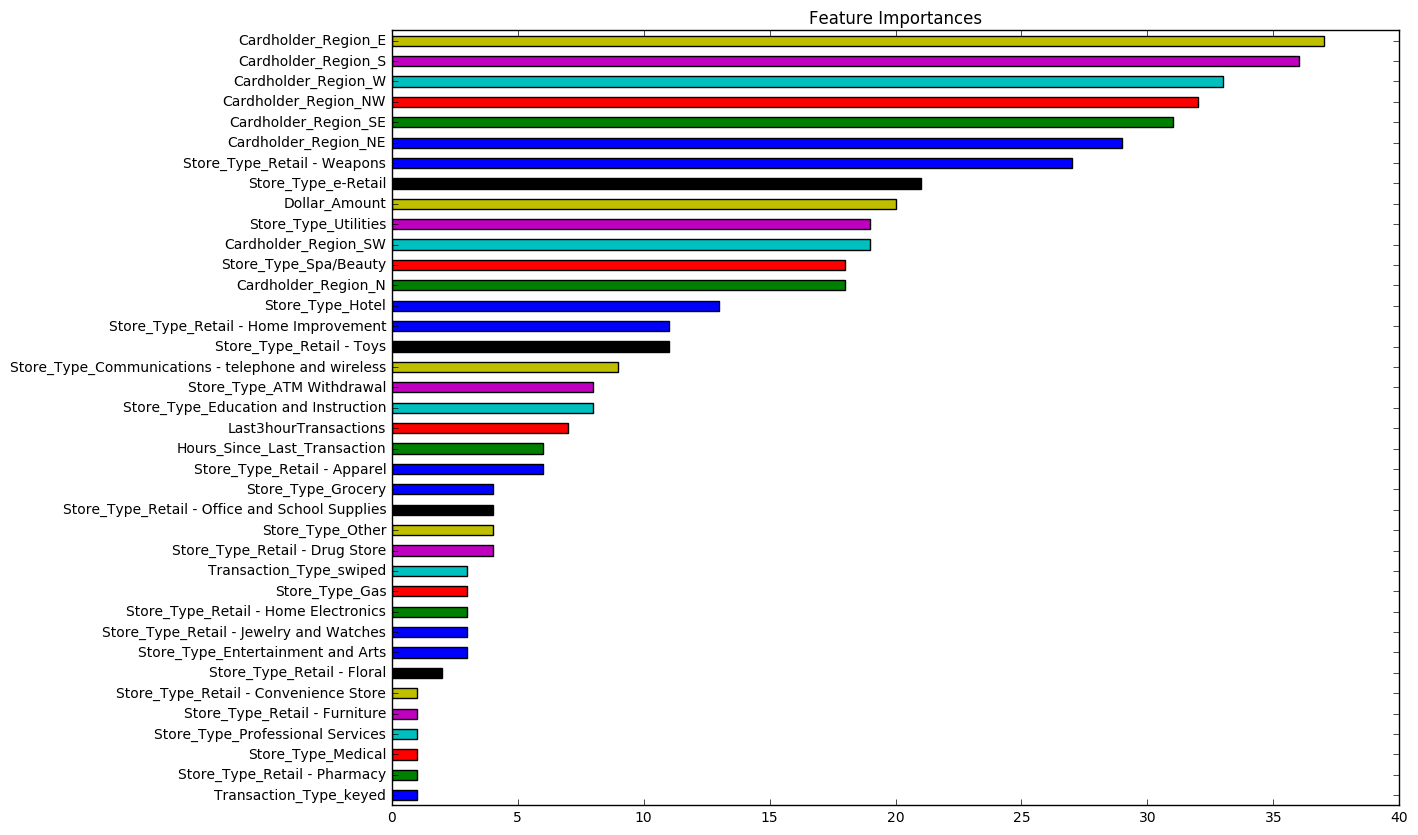

In [287]:
fig, axs = plt.subplots(nrows= 1, figsize=(13, 10))
feat_imp = pd.Series(pipeline.steps[1][1]._Booster.get_fscore()).sort_values()
X_train_dummy  =  pd.get_dummies(X_train_df)

x=[]
for i in range(0, X_train_dummy.shape[1]):
    x.append( "f"+ str(i))

X_train_dummy  = pd.get_dummies(X_train)    
feat_imp_reindex = feat_imp.rename(lambda y: dict(zip(x, X_train_dummy.columns.tolist()))[y])


feat_imp_reindex.plot(kind='barh', title='Feature Importances')

### Model Evaluation

In [155]:
pred_classifier = pipeline.predict(X_test)

In [156]:
roc = roc_auc_score(y_test, pred_classifier)
print("*****Confusion Matrix *****")
print(confusion_matrix(y_test, pred_classifier))
print("*****Classification Report*****")
print(classification_report(y_test, pred_classifier))
print("ROC: " +  str(roc))

*****Confusion Matrix *****
[[6372 4036]
 [ 214  385]]
*****Classification Report*****
             precision    recall  f1-score   support

          0       0.97      0.61      0.75     10408
          1       0.09      0.64      0.15       599

avg / total       0.92      0.61      0.72     11007

ROC: 0.627479632336


## Model Deployment using DSX Machine Learning

In [26]:
from dsx_ml.ml import save

Using TensorFlow backend.


In [154]:
model_name = "local_xgb"
save(name = model_name,
     model = pipeline,
     algorithm_type = 'Classification',
     x_test = X_test,
     y_test = pd.DataFrame(y_test))

{'path': '/user-home/1042/DSX_Projects/DTE FSS Fraud Detection/models/local_xgb/1',
 'scoring_endpoint': 'https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python35/scikit-learn-0.19/DTE%20FSS%20Fraud%20Detection/local_xgb/1'}

### Online Scoring

In [158]:
json_payload =[{
    'Dollar_Amount': 1000,
    'Transaction_Type':' keyed',
    'Store_Type': 'Retail - Furniture',
    'Cardholder_Region': 'SW',
    'Country': 'Asia',
    'Last3hourTransactions': 100,
    'Hours_Since_Last_Transaction': 12}]

In [159]:
import requests, json, os
from pprint import pprint

online_path='https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python35/scikit-learn-0.19/DTE%20FSS%20Fraud%20Detection/local_xgb/1'
header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(online_path, json=json_payload, headers=header_online)

response_dict = json.loads(response_scoring.content.decode('utf-8'))

pred=response_dict['object']['output']['predictions']
prob=response_dict['object']['output']['probabilities']
print("Prediction: %s" % pred)
print("Probabilities: %s" % prob)

Prediction: [0]
Probabilities: [[0.6900818347930908, 0.3099181652069092]]


### Batch Scoring

** Preparing data for Batch Scoring **

In [161]:
df_data_2 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/Current_Transactions_v6.csv')
df_data_2 = df_data_2[['Dollar_Amount', 
                       'Transaction_Type',
                       'Store_Type', 
                       'Cardholder_Region', 
                       'Country',
                       'Last3hourTransactions',
                       'Hours_Since_Last_Transaction'
                      ]]
df_data_2.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Last3hourTransactions,Hours_Since_Last_Transaction
0,171.72,keyed,Utilities,NW,USA,1,15
1,152.98,keyed,Retail - Books,NE,USA,2,21
2,126.30,swiped,Retail - Home Improvement,S,USA,1,18
3,126.30,swiped,Retail - Home Improvement,S,USA,2,14
4,181.16,keyed,Retail - Pharmacy,N,USA,2,23


** Batch Scoring **

Note: Modified the auto-generated script to make it work within notebook for batch scoring.

In [163]:
import pandas as pd
from sklearn import model_selection
from sklearn.externals import joblib
import pickle
import sys, os
import json
sys.path.insert(0, '/user-home/.scripts/common-helpers')
import published_model_util

# name your input and output data
test_csv = "Current_Transactions_v6_test2.csv" # dont have to 
save_csv = "yhat.csv"
args={'source': '/datasets/'+ test_csv, 'execution_type': 'DSX', 'target': '/datasets/'+ save_csv}
#input_data = os.getenv("DSX_PROJECT_DIR")+args.get("source")
output_data = os.getenv("DSX_PROJECT_DIR")+"/datasets/"+save_csv
model_name = 'local_xgb'
model_path = os.getenv("DSX_PROJECT_DIR")+"/models/"+model_name+"/1/model"
project_name = 'DTE FSS Fraud Detection'
is_published = 'false'

def scoring(model_path, input_data, output_data):
    published_path = ''
    # load model
    if is_published == 'true':
        copy_result = json.loads(published_model_util.copy_model(project_name, model_name))
        if(copy_result['code'] == 200):
            model_path = copy_result['path'] + '/model'
            published_path = copy_result['path']
        else:
            raise Exception('Unable to score published model: ' + copy_result['description'])

   # load the input data
    dataframe = input_data

    # load the model from disk 
    loaded_model = joblib.load(open(model_path, 'rb'))
    
    #predictions
    scoring_result = loaded_model.predict(dataframe)

    # feel free to write any code
    #print(scoring_result)
    scoring_output = pd.concat([dataframe.reset_index(drop=True), pd.DataFrame({'prediction':scoring_result})], 1)
    # save to csv
    scoring_output.to_csv(output_data)

    if (len(published_path) > 0):
        published_model_util.delete_temp_model()
    
    print("Done! The results have been saved as " + save_csv)
    
    return scoring_output

# invoke scoring: pay attention to input_data
batch_result = scoring(model_path,df_data_2, output_data)

Done! The results have been saved as yhat.csv


Here is the result returned by batch scoring.

In [165]:
batch_result.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Last3hourTransactions,Hours_Since_Last_Transaction,prediction
0,171.72,keyed,Utilities,NW,USA,1,15,0
1,152.98,keyed,Retail - Books,NE,USA,2,21,0
2,126.30,swiped,Retail - Home Improvement,S,USA,1,18,0
3,126.30,swiped,Retail - Home Improvement,S,USA,2,14,0
4,181.16,keyed,Retail - Pharmacy,N,USA,2,23,0


In [175]:
%brunel data("batch_result") bar x(prediction) y(#count) color(prediction: green-red) tooltip(#all)

<IPython.core.display.Javascript object>